In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, LSTM, GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [209]:
df=pd.read_csv('./HDFC.csv',index_col='Date',parse_dates=True)

In [210]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327


In [211]:
df['Date']=df.index

In [212]:
start_date='2011-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [213]:
df=df.loc[mask]

In [214]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [215]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [216]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [217]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [218]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (2427, 50) Y.shape (2427,)


In [219]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

LSTM+CNN

In [220]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPool1D()(x)
x=Dense(1)(x)
model_lstm_cnn=Model(i,x)
model_lstm_cnn.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 48, 25)            100       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_11 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_47 (Dense)            (None, 1)                 51 

In [221]:
check_point_lstm_cnn=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [222]:
model_lstm_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [223]:
r=model_lstm_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_cnn]
)

Epoch 1/100
53/53 [==============================] - 1s 10ms/step - loss: 298.8000 - mae: 12.8770 - mse: 298.8000 - val_loss: 1655.5948 - val_mae: 28.1763 - val_mse: 1655.5948
Epoch 2/100
53/53 [==============================] - 0s 7ms/step - loss: 292.1458 - mae: 12.7295 - mse: 292.1458 - val_loss: 1635.4163 - val_mae: 27.8994 - val_mse: 1635.4163
Epoch 3/100
53/53 [==============================] - 0s 6ms/step - loss: 290.6471 - mae: 12.6982 - mse: 290.6471 - val_loss: 1637.4445 - val_mae: 27.9478 - val_mse: 1637.4445
Epoch 4/100
53/53 [==============================] - 0s 6ms/step - loss: 289.9155 - mae: 12.6586 - mse: 289.9155 - val_loss: 1641.1348 - val_mae: 28.0311 - val_mse: 1641.1348
Epoch 5/100
53/53 [==============================] - 0s 7ms/step - loss: 288.1863 - mae: 12.6294 - mse: 288.1863 - val_loss: 1658.6389 - val_mae: 28.0835 - val_mse: 1658.6389
Epoch 6/100
53/53 [==============================] - 0s 6ms/step - loss: 288.1638 - mae: 12.6385 - mse: 288.1638 - val_loss:

LSTM+GRU

In [224]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=GRU(200,return_sequences=True)(x)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm_gru=Model(i,x)
model_lstm_gru.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_24 (LSTM)              (None, 50, 200)           161600    
                                                                 
 lstm_25 (LSTM)              (None, 50, 200)           320800    
                                                                 
 dense_48 (Dense)            (None, 50, 100)           20100     
                                                                 
 dense_49 (Dense)            (None, 50, 50)            5050      
                                                                 
 gru_12 (GRU)                (None, 50, 200)           151200    
                                                                 
 gru_13 (GRU)                (None, 50, 200)           241

In [225]:
check_point_lstm_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [226]:
model_lstm_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [227]:
r=model_lstm_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_gru]
)

Epoch 1/100
53/53 [==============================] - 38s 588ms/step - loss: 292.2749 - mae: 12.7108 - mse: 292.2749 - val_loss: 1637.9020 - val_mae: 27.8618 - val_mse: 1637.9020
Epoch 2/100
53/53 [==============================] - 29s 542ms/step - loss: 291.6108 - mae: 12.6884 - mse: 291.6108 - val_loss: 1635.9666 - val_mae: 27.8298 - val_mse: 1635.9666
Epoch 3/100
53/53 [==============================] - 28s 537ms/step - loss: 291.3432 - mae: 12.6877 - mse: 291.3432 - val_loss: 1636.0077 - val_mae: 27.8309 - val_mse: 1636.0077
Epoch 4/100
53/53 [==============================] - 28s 539ms/step - loss: 291.3225 - mae: 12.6907 - mse: 291.3225 - val_loss: 1636.7626 - val_mae: 27.8443 - val_mse: 1636.7626
Epoch 5/100
53/53 [==============================] - 28s 539ms/step - loss: 291.3675 - mae: 12.6741 - mse: 291.3675 - val_loss: 1636.3900 - val_mae: 27.8374 - val_mse: 1636.3900
Epoch 6/100
53/53 [==============================] - 28s 537ms/step - loss: 291.2974 - mae: 12.6828 - mse: 291

Predictions



In [228]:
train_idx[:T+1]=False

In [229]:
Ptrain_lstm_cnn=model_lstm_cnn.predict(Xtrain).flatten()
Ptest_lstm_cnn=model_lstm_cnn.predict(Xtest).flatten()

In [230]:
Ptrain_lstm_gru=model_lstm_gru.predict(Xtrain).flatten()
Ptest_lstm_gru=model_lstm_gru.predict(Xtest).flatten()

In [ ]:
df.loc[train_idx,'Diff LSTM+CNN train prediction']=Ptrain_lstm_cnn
df.loc[test_idx,'Diff LSTM+CNN test prediction']=Ptest_lstm_cnn

In [231]:
df.loc[train_idx,'Diff LSTM+GRU train prediction']=Ptrain_lstm_gru
df.loc[test_idx,'Diff LSTM+GRU test prediction']=Ptest_lstm_gru

In [232]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [233]:
last_train=train.iloc[-1]['Prev Close']

In [234]:
df.loc[train_idx,'train_LSTM_CNN']=prev[train_idx]+Ptrain_lstm_cnn
df.loc[test_idx,'Prediction_LSTM_CNN']=prev[test_idx]+Ptest_lstm_cnn

In [235]:
df.loc[train_idx,'train_LSTM_GRU']=prev[train_idx]+Ptrain_lstm_gru
df.loc[test_idx,'Prediction_LSTM_GRU']=prev[test_idx]+Ptest_lstm_gru

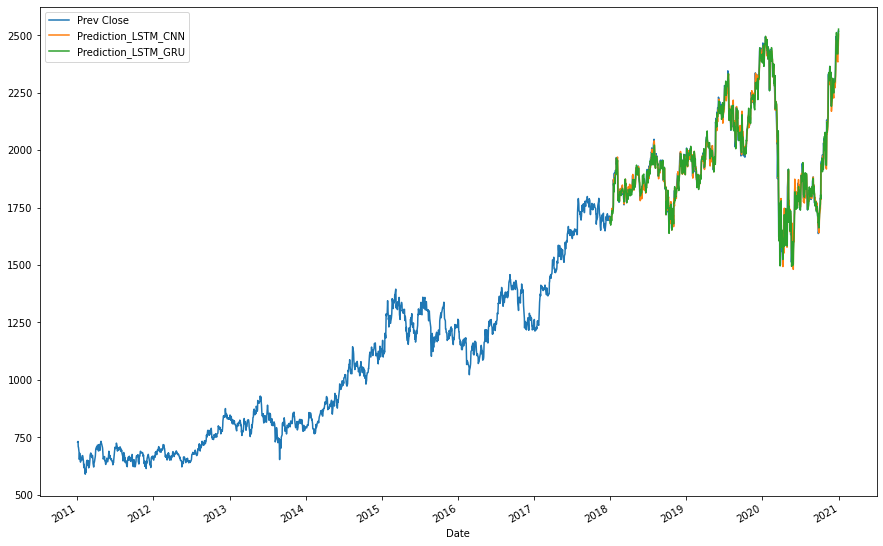

In [236]:
df[['Prev Close' ,'Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

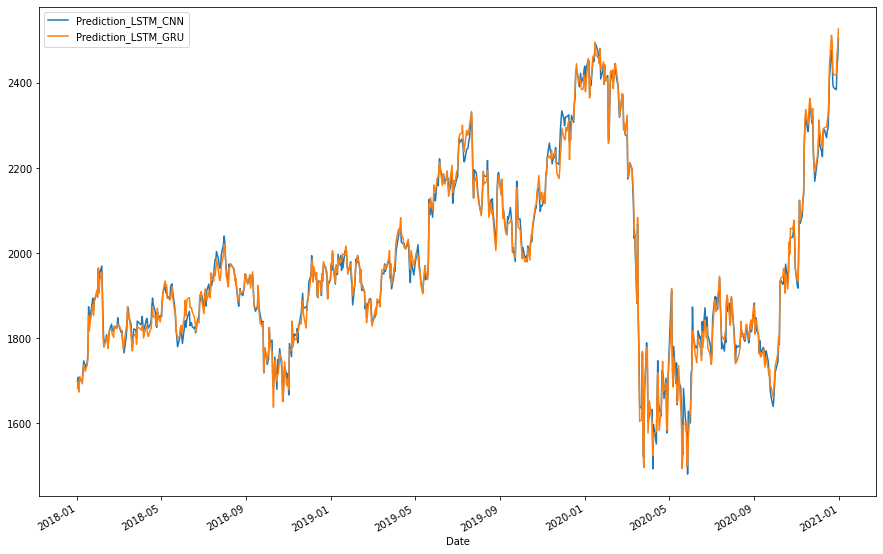

In [237]:
df[['Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

In [238]:
pred_lstm_cnn=df['Prediction_LSTM_CNN']
pred_lstm_cnn.dropna(inplace=True)

In [239]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

42.19269844312911


In [240]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_cnn)
print(error)

29.692318395967696


In [241]:
r2_score(test['Prev Close'],pred_lstm_cnn)

0.9627817472817297

In [242]:
pred_lstm_gru=df['Prediction_LSTM_GRU']
pred_lstm_gru.dropna(inplace=True)

In [243]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

42.19269844312911


In [244]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_gru)
print(error)

30.356736006301958


In [245]:
r2_score(test['Prev Close'],pred_lstm_gru)

0.9605040991810033